In [3]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

db = 'chinook.db'

def run_query(query):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(query, conn)

def run_command(command):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(command)
        
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table", "view");
    '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Genre popularity

In [4]:
q = '''
WITH usa_tracks AS (
    SELECT 
        g.name genre,
        COUNT(*) tracks_sold
    FROM invoice_line il
    INNER JOIN invoice i ON il.invoice_id = i.invoice_id
    INNER JOIN customer c ON i.customer_id = c.customer_id
    INNER JOIN track t ON t.track_id = il.track_id
    INNER JOIN genre g ON g.genre_id = t.genre_id
    WHERE c.country = "USA"
    GROUP BY 1
    ORDER BY 2 DESC
)

SELECT 
    genre,
    tracks_sold,
    tracks_sold * 100.0 / (SELECT SUM(tracks_sold) FROM usa_tracks) percentage
FROM usa_tracks u
'''
run_query(q)

,genre,tracks_sold,percentage
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Latin,22,2.093245
7,Pop,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


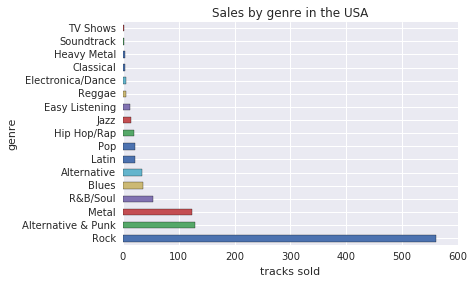

In [5]:
genre_sales = run_query(q)
genre_sales.set_index("genre", inplace=True)
genre_sales["tracks_sold"].plot.barh(
    title="Sales by genre in the USA"
)
plt.xlabel('tracks sold')


The store should purchase "Red Tone" and "Slim Jim Bites" according to genre sales. The store should buy some rock albums, as that is by far the most popular genre according to the data.

## Employee Performance

In [6]:
q2 = '''
WITH cust_totals AS (
    SELECT
        i.customer_id,
        SUM(i.total) total,
        c.support_rep_id
    FROM invoice i
    INNER JOIN customer c ON i.customer_id = c.customer_id
    GROUP BY i.customer_id
)

SELECT 
    e.first_name || " " || e.last_name employee_name,
    e.title,
    e.hire_date,
    SUM(cust.total) sales_total
FROM cust_totals cust
INNER JOIN employee e ON e.employee_id = cust.support_rep_id
GROUP BY employee_name

'''
run_query(q2)

,employee_name,title,hire_date,sales_total
0,Jane Peacock,Sales Support Agent,2017-04-01 00:00:00,1731.51
1,Margaret Park,Sales Support Agent,2017-05-03 00:00:00,1584.00
2,Steve Johnson,Sales Support Agent,2017-10-17 00:00:00,1393.92


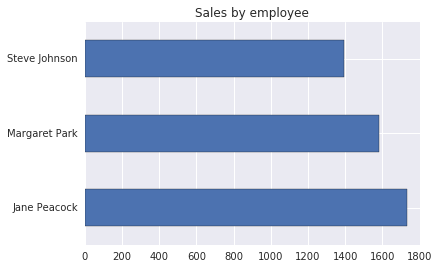

In [7]:
employee_sales = run_query(q2)
employee_sales.set_index("employee_name", inplace=True)
employee_sales.plot.barh(title="Sales by employee", legend=False)

plt.ylabel('')

Jane has the most sales, but she's also been working the longest. Overall when accounting for the hiring date, everyone seems to be relatively even. 

## Analyzing Sales By Country

In [8]:
q3 = '''
WITH country_grouping AS (
    SELECT 
        c.customer_id,
        i.total,
        CASE
            WHEN (
                SELECT COUNT(*)
                FROM customer 
                WHERE country = c.country
            ) = 1 THEN "Other" ELSE c.country
            END AS country
    FROM customer c
    INNER JOIN invoice i ON c.customer_id = i.customer_id
)

SELECT 
    country,
    COUNT(DISTINCT(customer_id)) total_customers,
    SUM(total) total_sales,
    SUM(total) / COUNT(DISTINCT(customer_id)) avg_sales_per_cust,
    AVG(total) avg_order
FROM country_grouping cg
GROUP BY country
ORDER BY (
    CASE
        WHEN country = "Other" THEN 1 ELSE 0
    END
), total_sales DESC
'''
run_query(q3)

,country,total_customers,total_sales,avg_sales_per_cust,avg_order
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


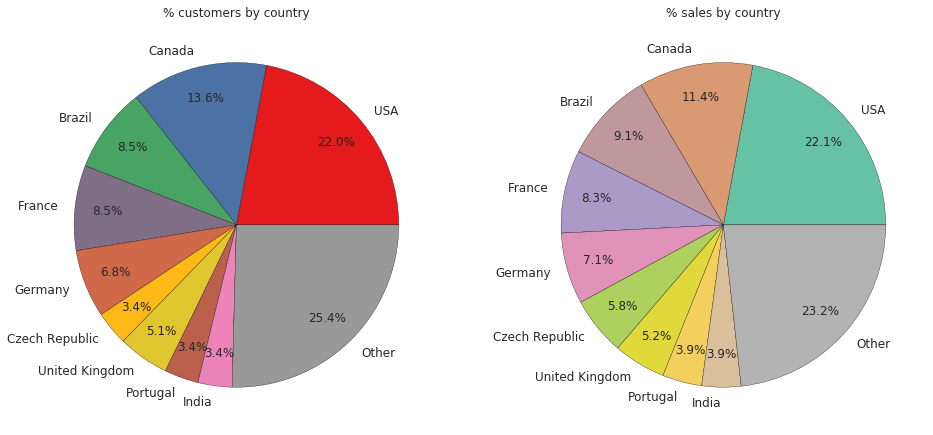

In [18]:
sales_country = run_query(q3)

fig1 = plt.figure(figsize=(16,16))

ax1 = fig1.add_subplot(2,2,1)
sales_country["total_customers"].plot.pie(
    title="% customers by country",
    labels=sales_country["country"],
    colormap=plt.cm.Set1,
    fontsize=12,
    pctdistance=0.8,
    autopct='%.1f%%')
ax1.set_ylabel('')

ax2 = fig1.add_subplot(2,2,2)
sales_country["total_sales"].plot.pie(
    title="% sales by country",
    colormap=plt.cm.Set2,
    fontsize=12,
    pctdistance=0.8,
    labels=sales_country["country"],
    autopct='%.1f%%')
ax2.set_ylabel('')

plt.show()

Based on the charts, the Czech Republic spends more per person, although it's a small sample size. The store should still focus their sales in the US.

## Album vs Individual Track Purchases

Key thing to note is that customers cannot buy an album and other individual tracks in a purchase. 

In [59]:
q4 = '''
WITH 
invoice_tracks AS (
    SELECT 
        t.album_id,
        t.track_id,
        i.invoice_id,
        i.total
    FROM invoice i
    INNER JOIN invoice_line il ON i.invoice_id = il.invoice_id
    INNER JOIN track t ON il.track_id = t.track_id
    GROUP BY i.invoice_id
),

album_purchases AS (
    SELECT 
    it.*,
    CASE
        WHEN
            (
            SELECT t.track_id FROM track t 
            WHERE t.album_id = it.album_id
            EXCEPT 

            SELECT il.track_id FROM invoice_line il
            WHERE il.invoice_id = it.invoice_id
            ) IS NULL
         AND
            (
            SELECT il.track_id FROM invoice_line il
            WHERE il.invoice_id = it.invoice_id

            EXCEPT 

            SELECT t.track_id FROM track t
            WHERE t.album_id = it.album_id
            ) IS NULL 
        THEN 'Yes'
        ELSE 'No'
    END AS is_album_purchase
FROM invoice_tracks it     
)

SELECT 
    is_album_purchase,
    SUM(ap.total) total_sales,
    SUM(ap.total) * 1.0 / (SELECT SUM(total) FROM invoice) percent_sales,
    COUNT(*) total_invoices,
    COUNT(*) * 1.0 / (SELECT COUNT(*) FROM album_purchases) percent_invoices
FROM album_purchases ap
GROUP BY 1

'''
run_query(q4)

,is_album_purchase,total_sales,percent_sales,total_invoices,percent_invoices
0,No,3248.19,0.68972,500,0.814332
1,Yes,1461.24,0.31028,114,0.185668
